# Crop Classification

## Setup
<hr>

In [123]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.optimizers import Nadam

from keras_tuner.tuners import Hyperband

from tifffile import TiffFile
from dbfread import DBF
from pandas import DataFrame
from skimage.util import view_as_windows, view_as_blocks
from functools import partial
from datetime import datetime

logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
modeldir = "models"


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
mpl.rc('figure' ,figsize=[12, 12])
mpl.rc('figure', dpi=72)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
np.random.seed(27)
rng = np.random.default_rng()

## Load Data
<hr>

In [4]:
def raster_to_numpy_array(filename):
    return np.array(TiffFile(filename).asarray())


full_training_data = raster_to_numpy_array(
    os.path.join("data", "20130824_RE3_3A_Analytic_Champaign_north.tif")
)

training_data_labels = raster_to_numpy_array(
    os.path.join("data", "CDL_2013_Champaign_north.tif")
)


In [5]:
label_mapping = DataFrame(
    iter(
        DBF(os.path.join("data", "CDL_2013_clip_20170525181724_1012622514.tif.vat.dbf"))
    )
)


### Data Metadata

 There should be 5 bands in the imagery data. Because the training data label raster shares the same projection as the imagery data and was resampled from 30m/pixel to 5m/pixel to match it's resolution, they should have the same dimensions.

In [6]:
# Training data has 5 bands
print(full_training_data.shape[2])

# Training data and label have the same shape
print(full_training_data.shape[:2])
print(training_data_labels.shape)


5
(5959, 9425)
(5959, 9425)


The RapidEye product specification I found says the pixel depth is 16 bits, unsigned. Does that match the data?

In [7]:
print(full_training_data.max(axis=(0, 1)))
print(full_training_data.min(axis=(0, 1)))


[35709 35412 31680 24759 24381]
[0 0 0 0 0]


Not sure. These values seem pretty low. Perhaps there are simply no bright colors. It shouldn't be a problem as these values will be normalized anyway. 

What about the label data?

In [8]:
print([training_data_labels.min(), training_data_labels.max()])
print([label_mapping["VALUE"].min(), label_mapping["VALUE"].max()])
print()

print(label_mapping[label_mapping["VALUE"] == 0])
print(label_mapping[label_mapping["CLASS_NAME"] == "Corn"])
print(label_mapping[label_mapping["CLASS_NAME"] == "Soybeans"])


[1, 254]
[0, 254]

   VALUE  CLASS_NAME  RED  GREEN  BLUE  OPACITY
0      0  Background  0.0    0.0   0.0      0.0
   VALUE CLASS_NAME  RED     GREEN  BLUE  OPACITY
1      1       Corn  1.0  0.827451   0.0      1.0
   VALUE CLASS_NAME      RED     GREEN  BLUE  OPACITY
5      5   Soybeans  0.14902  0.439216   0.0      1.0


This checks out. I guess Background is never used as are probably many others. Corn (1) and Soybeans (5) are the important ones.

I'll remove everything else and give soybeans a value of 2 so the values are continguous integers.

In [9]:
get_label_value = lambda pixel_value: {5: 2, 1: 1}.get(pixel_value, 0)
simple_training_data_labels = np.vectorize(get_label_value)(training_data_labels)

np.unique(simple_training_data_labels)


array([0, 1, 2])

### Removing Missing Data


It seems like some of the training data imagery is missing from the extent of the labeled data. Note the black around the borders

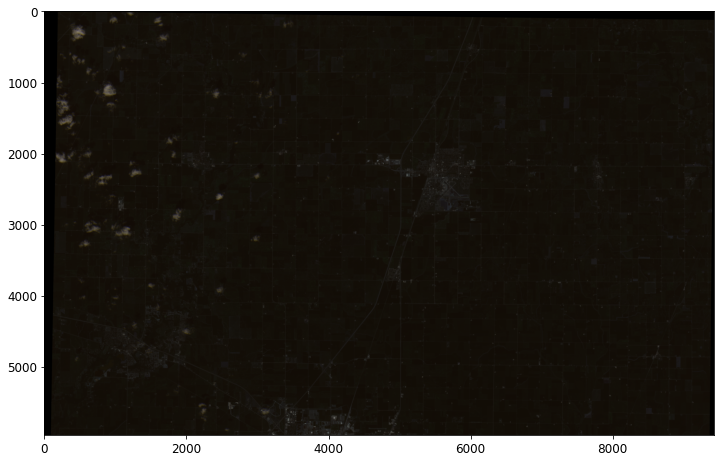

In [10]:
def plt_rgb(data, bit_depth=16):
    rgb = data[:, :, :3]
    plt.imshow(rgb / 2 ** bit_depth)


plt_rgb(full_training_data)
plt.show()


While the labeled data fills the rectange:

/Users/mstone18/stuff/crop_classification/env/lib/python3.9/site-packages/matplotlib/colors.py:373: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rgba = np.array(c)


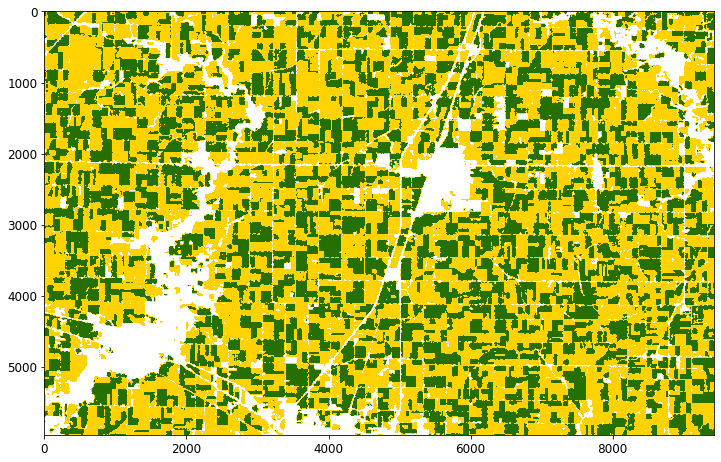

In [11]:
corn_row = label_mapping[label_mapping["CLASS_NAME"] == "Corn"]
corn_color = (corn_row["RED"], corn_row["GREEN"], corn_row["BLUE"], corn_row["OPACITY"])

soybean_row = label_mapping[label_mapping["CLASS_NAME"] == "Soybeans"]
soybean_color = (
    soybean_row["RED"],
    soybean_row["GREEN"],
    soybean_row["BLUE"],
    soybean_row["OPACITY"],
)

cmap = plt_colors.ListedColormap([(0, 0, 0, 0), corn_color, soybean_color])
bounds = [0, .5, 1.5, 2.5]
norm = plt_colors.BoundaryNorm(bounds, cmap.N)

def plt_labels(data):
    plt.imshow(data, cmap=cmap, norm=norm)


plt_labels(simple_training_data_labels)
plt.show()


If the model is looking for data where it doesn't exist, it will throw off the model. The simplest way to get around this is to crop the data set to remove the areas with missing data.

In [12]:
# A function that takes a row or column of band values (n, 5) and returns the non-empty indices
def get_non_empty_indices(array):
    return np.where(np.any(array > 0, axis=1))[0]


# First non-empty (0,0,0,0,0) pixel in the first row
start_pixel_column = get_non_empty_indices(full_training_data[0])[0]

# Last non-empty pixel in the last row
end_pixel_column = get_non_empty_indices(full_training_data[-1])[-1]

# First non-empty pixel in the end_pixel_column
start_pixel_row = get_non_empty_indices(full_training_data[:, end_pixel_column])[0]

# Last non-empty pixel in the start_pixel_column
end_pixel_row = get_non_empty_indices(full_training_data[:, start_pixel_column])[-1]

print([[start_pixel_row, start_pixel_column], [end_pixel_row, end_pixel_column]])


[[125, 196], [5958, 9363]]


These two points define the new bounding box of the training data. Now to crop:

In [13]:
cropped_training_data = full_training_data[
    start_pixel_row:end_pixel_row, start_pixel_column:end_pixel_column
]
cropped_training_data.shape


(5833, 9167, 5)

Plotting the image again should verify the black areas are no longer inside the study area.

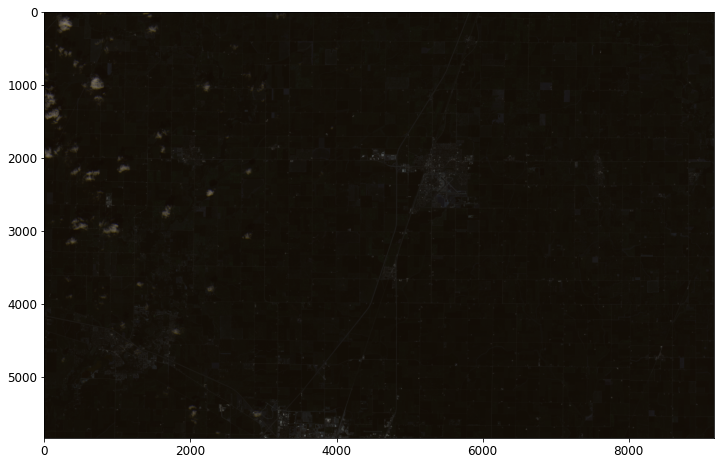

In [14]:
plt_rgb(cropped_training_data)
plt.show()

Now to crop the training data labels with the same coordinates.

In [15]:
cropped_training_data_labels = simple_training_data_labels[
    start_pixel_row:end_pixel_row, start_pixel_column:end_pixel_column
]
cropped_training_data_labels.shape


(5833, 9167)

### Chunking Data

Ultimately this is an semantic segmentation problem. The goal is classify each pixel in an image as being either corn, soybean or anything else. We don't care about grouping individual farms, only what crop the pixel is. Convolutional nueral networks are good for any type of computer vision, including semantic segmentation. 

Normally when training a semantic segmentation model, many labeled pictures are used. With this assignment, all I have is one large image and its classification. While it would be nice to train model on the entire image (or at least the non-validation part of it) at once, the backpropagation calculations would probably require way too much memory.

Instead, I'm going to have to break up the data into chunks. Unfortunately this means there will probably be some data loss. Fields and their boundaries might get abitrarily divided which might reduce the effectiveness of the model. I hope to mitigate this by overlapping the chunks of data. Each new chunk will set as its midpoint, the border of the last chunk. That way features that lie on the edge on one chunk will be in the center of the next. 

#### Chunk Size

The chunk size will probably have a large effect on the performance and accuracy of the model. It needs to be small enough to fit into memory and keep the model performant, but large enough to pick up on patterns that can identify crops. 

My guess is that the patterns which will be most effective at distinguishing between corn and soybean will be at the subfield scale. At the field-scale (at least from a remote sensing perspective), corn and soybean are mostly the same. The size of corn and soybean fields are not drastically different and their geometry is determined more by geographical, municipal and residential borders than agricultural properties.

This means I can probably keep the chunk size pretty small and still get accurate results. I don't need to have many fields in the same chunk in order for inter-field patterns to be recognized because those patterns aren't likely to distinguish between corn and soybean.

In [16]:
chunk_width = 128 # 640 meters
chunk_length = 128
number_of_bands = cropped_training_data.shape[2]

# view_as_windows requires the slices and step parameters match the dimension of the passed array,
# so each band is processed separately and then rejoined after
all_training_chunks = np.array(
    [
        view_as_windows(
            cropped_training_data[:, :, band],
            [chunk_width, chunk_length],
            [chunk_width // 2, chunk_length // 2],
        )
        for band in range(number_of_bands)
    ]
)

all_training_chunks = np.moveaxis(all_training_chunks, 0, -1)

all_training_chunks = all_training_chunks.reshape(
    (
        all_training_chunks.shape[0] * all_training_chunks.shape[1],
        chunk_width,
        chunk_length,
        number_of_bands,
    ),
)


all_training_chunks.shape


(12780, 128, 128, 5)

The shape looks right. A plot of a few of the chunks should verify.

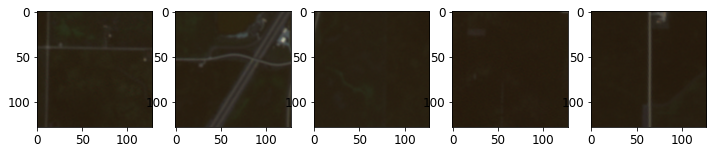

In [17]:
plt.figure()

for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt_rgb(
        all_training_chunks[np.random.randint(0, all_training_chunks.shape[0])],
        bit_depth=15,  # this effectively brings up the brightness, making it easier to discern detail
    )


plt.show()


The pictures don't appear distored and the colors look about the same as the original.

Now to chunk the training data labels.

In [18]:
training_data_labels_chunked = view_as_windows(
    cropped_training_data_labels,
    [chunk_width, chunk_length],
    [chunk_width // 2, chunk_length // 2],
)

training_data_labels_chunked = training_data_labels_chunked.reshape(
    (
        training_data_labels_chunked.shape[0] * training_data_labels_chunked.shape[1],
        chunk_width,
        chunk_length,
    ),
)

training_data_labels_chunked.shape


(12780, 128, 128)

The training label data has the same number of chunks as the actual training data. This is a good sign.

It might also be a good idea to check that the imagery and labels line up correctly for a few chunks.

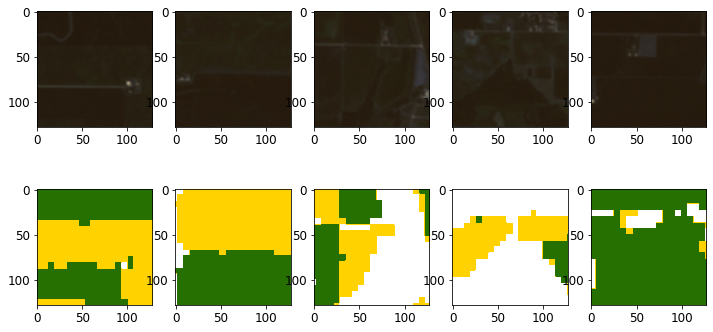

In [19]:
plt.figure(figsize=(12, 6))
chunk_indicies = np.random.randint(0, all_training_chunks.shape[0], 5)

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt_rgb(
        all_training_chunks[chunk_indicies[i]],
        bit_depth=15,  # this effectively brings up the brightness, making it easier to discern detail
    )

    plt.subplot(2, 5, i + 6)
    plt_labels(training_data_labels_chunked[chunk_indicies[i]])

plt.show()


It's hard to be sure, but there seem to be some features that line up. It also looks like some areas might be misclassified. Without actual ground truth, my model might end up training itself to match the CDL model (and its mistakes) rather than what's actually on the ground.

### Normalize the Data

The imagery data must be normalized before it can be used by the model.

In [20]:
normalized_training_chunks = all_training_chunks / 2 ** 16
print([normalized_training_chunks.min(), normalized_training_chunks.max()])

[0.0160369873046875, 0.5448760986328125]


### Creating Training, Validation and Test Sets

I'm going to split the full training data into two sets. 

- Training (80%): This set will be used to train the model.
- Validation (20%): After training the model this set will be used to evaluate its performance. If the model is much less accurate on this data set, then it is likely that the model is overfitting the training data. The results from the validation set also offer a better metric for comparing models with different hyperparameters. 

I'm considering the South Illinois data the test set. This means I won't be able to make a final analysis of the model, but that shouldn't be a problem because the model adjustments will come from the validation set, not the test set.

In [21]:
# shuffle training and labels with the same sequence
random_indicies = np.random.permutation(normalized_training_chunks.shape[0])
random_training_chunks = normalized_training_chunks[random_indicies]
random_label_chunks = training_data_labels_chunked[random_indicies]

split_point = int(len(random_indicies) * 0.8)

training_X = random_training_chunks[:split_point]
training_Y = random_label_chunks[:split_point]

validation_X = random_training_chunks[split_point:]
validation_Y = random_label_chunks[split_point:]

print([training_X.shape, training_Y.shape])
print([validation_X.shape, validation_Y.shape])



[(10224, 128, 128, 5), (10224, 128, 128)]
[(2556, 128, 128, 5), (2556, 128, 128)]


## Training the Model

I'm going to use a convolutional neural network for my model as these are often used for computer vision problems. I'm going to have to limit the size of the network because I do not have access to a CUDA GPU and won't be able to take advantage of tensorflow's GPU utilization capabilities. Also, usually in a problem such as this, I would start with a pretrained model, freeze the bottom layers and train the top on this data. The problem with this approach is that the built-in tensorflow models for imagery adhere to a strict input pattern which includes only 3 bands. I think using all 5 bands will provide the most accurate model, so instead I'll create my own. It is going have to be pretty simple anyway because I'm limited to using only the CPU. 

Like I mentioned earlier, I'm guessing that the crop field patterns are pretty small, so in my first attempt I'm going to stick to smaller kernel sizes. For the same reasons, I'm not going to use any pooling. This means I won't have to upsample. 

To start I'll use two convolutional layers with kernel size 3 and the ReLU activation function. The first will have 32 filters and the second will have 64. Often neural networks are structured with fewer filters at the bottom layers to pick up on general patterns and more filters on higher layers to identify more complex patterns. Finally, a Dense layer with 3 units and the Softmax activation function will determine the probability with which it thinks each pixel belongs to each category.

I'll use the `sparse_categorical_crossentropy` loss function since there are more than two label classes. I'll start out with the NAdam optimizer.

In [27]:
DefaultConv2D = partial(Conv2D, kernel_size=3, activation="relu", padding="SAME")

model = Sequential(
    [
        Input(shape=[chunk_width, chunk_length, 5]),
        DefaultConv2D(filters=32),
        DefaultConv2D(filters=64),
        Dense(units=3, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      1472      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 dense_1 (Dense)             (None, 128, 128, 3)       195       
                                                                 
Total params: 20,163
Trainable params: 20,163
Non-trainable params: 0
_________________________________________________________________


In [28]:
# The tensor board provides a nice visualization of metrics as the model is training
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)


# Commenting this out so it doesn't hold up future run-throughs of the playbook
#
# history = model.fit(
#     training_X,
#     training_Y,
#     epochs=10,
#     validation_data=(validation_X, validation_Y),
#     callbacks=[tensorboard_callback],
# )


Epoch 1/10
320/320 [==============================] - 178s 556ms/step - loss: 0.7457 - accuracy: 0.6849 - val_loss: 0.6706 - val_accuracy: 0.7264
Epoch 2/10
320/320 [==============================] - 167s 521ms/step - loss: 0.6459 - accuracy: 0.7357 - val_loss: 0.6216 - val_accuracy: 0.7475
Epoch 3/10
320/320 [==============================] - 168s 524ms/step - loss: 0.5968 - accuracy: 0.7659 - val_loss: 0.5608 - val_accuracy: 0.7856
Epoch 4/10
320/320 [==============================] - 168s 525ms/step - loss: 0.5517 - accuracy: 0.7949 - val_loss: 0.5690 - val_accuracy: 0.7903
Epoch 5/10
320/320 [==============================] - 170s 531ms/step - loss: 0.5127 - accuracy: 0.8174 - val_loss: 0.6048 - val_accuracy: 0.7659
Epoch 6/10
320/320 [==============================] - 167s 522ms/step - loss: 0.4912 - accuracy: 0.8281 - val_loss: 0.5447 - val_accuracy: 0.7905
Epoch 7/10
320/320 [==============================] - 936s 3s/step - loss: 0.4669 - accuracy: 0.8401 - val_loss: 0.4486 - va

Since that took over half an hour. I'm going to save it before I do anything else.

In [29]:
def save_model_with_date(model):
    save_model(model, os.path.join(modeldir, datetime.now().strftime("%Y%m%d-%H%M%S")))


# save_model_with_date(model)

# Future run throughts of the playbook will load the model instead
model = load_model(os.path.join(modeldir, "20220128-202001"))


2022-01-28 22:34:25.767140: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/20220128-223425/assets


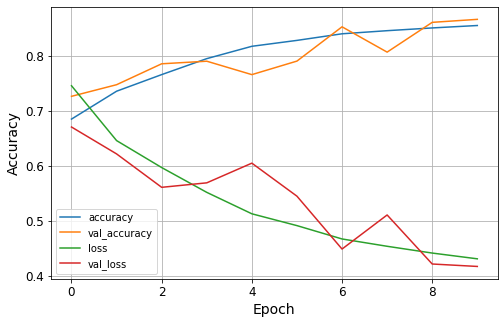

In [30]:
def plot_history(history, lines=["accuracy", "val_accuracy", "loss", "val_loss"]):
    plt.figure(figsize=(8, 5))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid()

    for line in lines:
        plt.plot(history[line], label=line)

    plt.legend()
    plt.show()

# Note: This won't work with the loaded model
# plot_history(history.history)


The accuracy ended up around .85. This seems pretty decent. What is more important is that the validation accuracy is about the same as the training accuracy. This means the model is not overfitting the training data set.

The loss values appear to be decreasing and would probably decrease even more if I ran a few more epochs.

It would be nice to verify some of these results visually.

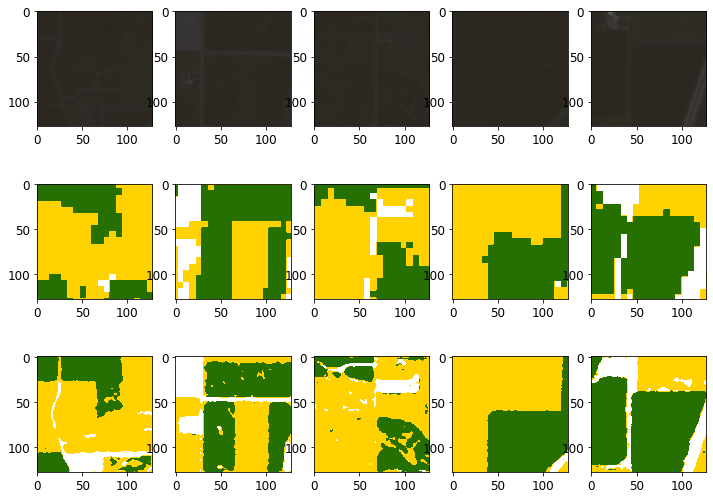

In [168]:
plt.figure(figsize=(12, 9))
chunk_indicies = np.random.randint(0, validation_X.shape[0], 5)
predictions = model(validation_X[chunk_indicies])

# The model returns predictions as probabilites.
# argmax will convert this to the class based on the max probability's index.
predictions = np.argmax(predictions, axis=-1)

for i in range(5):
    plt.subplot(3, 5, i + 1)
    # validation_X has been normalized, so just pass it directly to imshow
    # Adding .1 should make the pictures a little brighter
    plt.imshow(validation_X[chunk_indicies[i]][:, :, :3] + 0.1)

    plt.subplot(3, 5, i + 6)
    plt_labels(validation_Y[chunk_indicies[i]])

    plt.subplot(3, 5, i + 11)
    plt_labels(predictions[i])

plt.show()


Seems like it's doing pretty well. Some times it's labeling roads as corn. Both the CDL and my model seem to agree on developed areas being neither corn or soybean. 

### Modifying Hyperparameters

I'm going to use the Keras tuner mostly because it should be easy to configure with the Keras model. I'll be using a Hyperband tuner.

I'm extending the range of the kernel size hyperparameter down to 1. My thinking here is that the algorithm might possibly have all the information it needs within the 5 bands (especially the non-visible bands) to determine crop type. This would effectively make the network non-convolutional.

Other hyperparameters include the number of filters in the two convolutional layers, the activation function and the learning rate.

In [47]:
def hypermodel(hp):
    DefaultConv2D = partial(
        Conv2D,
        kernel_size=hp.Int("kernel_size", min_value=1, max_value=5, step=1),
        activation=hp.Choice("activation", values=["elu", "relu"]),
        padding="SAME",
    )

    model = Sequential(
        [
            Input(shape=[chunk_width, chunk_length, 5]),
            DefaultConv2D(
                filters=hp.Int("layer1_filters", min_value=16, max_value=64, step=16)
            ),
            DefaultConv2D(
                filters=hp.Int("layer2_filters", min_value=32, max_value=128, step=32)
            ),
            Dense(units=3, activation="softmax"),
        ]
    )

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Nadam(
            learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        metrics=["accuracy"],
    )

    return model

tuner = Hyperband(
    hypermodel,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="models",
    project_name="hypermodel_1",
)

tuner.search_space_summary()


Search space summary
Default search space size: 5
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'elu', 'conditions': [], 'values': ['elu', 'relu'], 'ordered': False}
layer1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
layer2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [48]:
# tuner.search(
#     training_X,
#     training_Y,
#     epochs=25,
#     validation_data=[validation_X, validation_Y],
#     callbacks=[
#         TensorBoard(logdir, histogram_freq=1),
#         EarlyStopping(
#             monitor="val_loss", patience=5
#         ),  # Stop if the model is not getting anywhere
#     ],
# )


Trial 30 Complete [00h 32m 26s]
val_accuracy: 0.8461975455284119

Best val_accuracy So Far: 0.8569303750991821
Total elapsed time: 08h 33m 08s
INFO:tensorflow:Oracle triggered exit


In [49]:
# First run looks good. I'm going to run it again to see if it can improve the accuracy.

# tuner.search(
#     training_X,
#     training_Y,
#     epochs=25,
#     validation_data=[validation_X, validation_Y],
#     callbacks=[
#         TensorBoard(logdir, histogram_freq=1),
#         EarlyStopping(
#             monitor="val_loss", patience=5
#         ),  # Stop if the model is not getting anywhere
#     ],
# )

Trial 42 Complete [00h 53m 01s]
val_accuracy: 0.8629836440086365

Best val_accuracy So Far: 0.8629836440086365
Total elapsed time: 16h 34m 56s
INFO:tensorflow:Oracle triggered exit


The accuracy doesn't seem to be improving much. Since I'm running out of time, I think I'm going to have to stop here. Unfortunately, parameterizing the model did not seem to offer much improvement over the original. Maybe I can coax a little more accuracy by training just the best model for a few more epochs. 

In [60]:
parameters = [
    "kernel_size",
    "activation",
    "layer1_filters",
    "layer2_filters",
    "learning_rate",
]

best_parameters = tuner.get_best_hyperparameters()[0]

for parameter in parameters:
    print("%s: %s" % (parameter, best_parameters.get(parameter)))

best_model = tuner.hypermodel.build(best_parameters)
best_model.summary()


kernel_size: 4
activation: elu
layer1_filters: 48
layer2_filters: 64
learning_rate: 0.001
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 48)      3888      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      49216     
                                                                 
 dense_3 (Dense)             (None, 128, 128, 3)       195       
                                                                 
Total params: 53,299
Trainable params: 53,299
Non-trainable params: 0
_________________________________________________________________


In [61]:
# history = best_model.fit(training_X, training_Y, epochs=10, validation_split=0.2)

Epoch 1/10
256/256 [==============================] - 278s 1s/step - loss: 0.7499 - accuracy: 0.6902 - val_loss: 0.6668 - val_accuracy: 0.7429
Epoch 2/10
256/256 [==============================] - 273s 1s/step - loss: 0.6390 - accuracy: 0.7430 - val_loss: 0.6061 - val_accuracy: 0.7524
Epoch 3/10
256/256 [==============================] - 260s 1s/step - loss: 0.5989 - accuracy: 0.7665 - val_loss: 0.5972 - val_accuracy: 0.7722
Epoch 4/10
256/256 [==============================] - 261s 1s/step - loss: 0.5606 - accuracy: 0.7903 - val_loss: 0.5335 - val_accuracy: 0.8056
Epoch 5/10
256/256 [==============================] - 263s 1s/step - loss: 0.5386 - accuracy: 0.8044 - val_loss: 0.4956 - val_accuracy: 0.8311
Epoch 6/10
256/256 [==============================] - 262s 1s/step - loss: 0.5143 - accuracy: 0.8150 - val_loss: 0.4900 - val_accuracy: 0.8313
Epoch 7/10
256/256 [==============================] - 263s 1s/step - loss: 0.5017 - accuracy: 0.8207 - val_loss: 0.4797 - val_accuracy: 0.8287

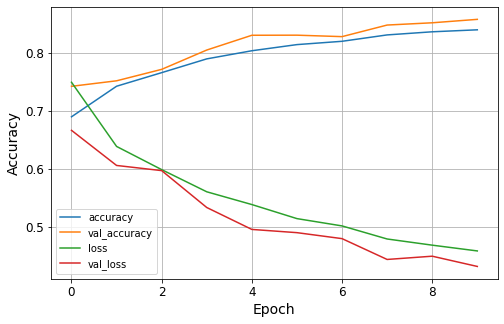

In [63]:
# plot_history(history.history)

The accuracy is still hovering around .85. The deadline is tomorrow, so I'm going to stop here. If I had more time, there are a few things I would try.

I noticed earlier that imagery does contain some cloud cover. Since there is no way to determine crop type through clouds, these pixels will throw off the model, preventing it from reaching a higher accuracy. I could write some code to filter out chunks with clouds. Chunks that contain a certain number of white pixels could be excluded or perhaps the non-visible bands could assist in identifying clouds as well. 

I wish I had given the two Convolutional layers separate kernel size hyperparameters. I think that perhaps the lower layer could have used a smaller kernel to determine basic patterns and the higher layer could have used a larger kernel to identify more complex patterns. 

If I had access to a CUDA GPU, I think this model would train much faster. In that case, I would probably add more hyperparameters. There are other activation functions and optimizers that I could try. I would like to experiment with different chunk sizes as well. I could also add more layers to the base model, including some pooling layers and a few non-output, Dense layers.


In [163]:
# save_model(model, os.path.join(modeldir, "best_model"))

model = load_model(os.path.join(modeldir, "best_model"))

## Predicting the South

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


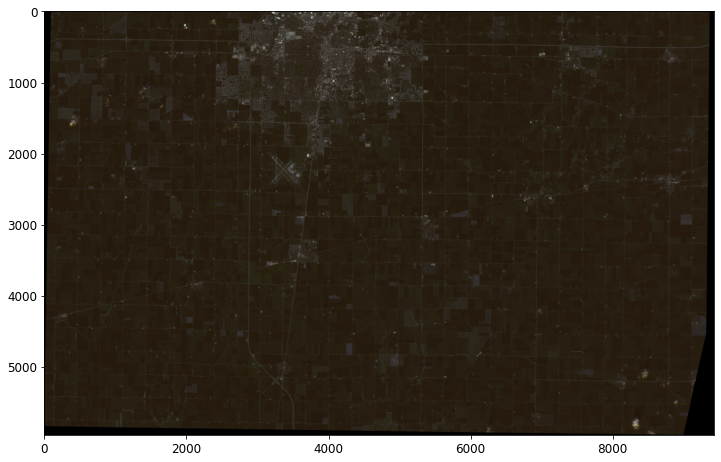

In [157]:
original_test_data = raster_to_numpy_array(
    os.path.join("data", "20130824_RE3_3A_Analytic_Champaign_south.tif")
)

plt_rgb(original_test_data, bit_depth=15)


In [159]:
# normalize
normalized_test_data = original_test_data / 2 ** 16

# Crop to multiple of chunk_size
chunk_row_count = normalized_test_data.shape[0] // chunk_width
chunk_col_count = normalized_test_data.shape[1] // chunk_length

test_data = normalized_test_data[
    : chunk_row_count * chunk_width,
    : chunk_col_count * chunk_length,
]

# chunk data (way easier without overlaps)

# so each band is processed separately and then rejoined after
test_data_chunks = np.array(
    [
        view_as_blocks(test_data[:, :, band], (chunk_width, chunk_length))
        for band in range(number_of_bands)
    ]
)

test_data_chunks = np.moveaxis(test_data_chunks, 0, -1)

test_data_chunks = test_data_chunks.reshape(
    (
        test_data_chunks.shape[0] * test_data_chunks.shape[1],
        chunk_width,
        chunk_length,
        number_of_bands,
    ),
)

test_data_chunks.shape

(3358, 128, 128, 5)

In [174]:
predictions = model.predict(test_data_chunks)

In [126]:
# # Only want the most probable class
max_predictions = np.argmax(predictions, axis=-1)

# final_figure = np.swapaxes(max_predictions, 1, 2)
# final_figure = final_figure.reshape(
#     (chunk_row_count * chunk_width, chunk_col_count * chunk_length),
# )

arranged = []
for chunk_row in range(chunk_row_count):
    arranged_row = [[] for i in range(chunk_length)]
    for chunk_col in range(chunk_col_count):
        index = chunk_row * chunk_col_count + chunk_col
        print("Adding chunk %d  \r" % index, end="")

        chunk = max_predictions[index]
        for i in range(chunk_length):
            arranged_row[i].extend(chunk[i])

    for row in arranged_row:
        arranged.append(row)


final_figure = np.array(arranged)
final_figure.shape


(5888, 9344)

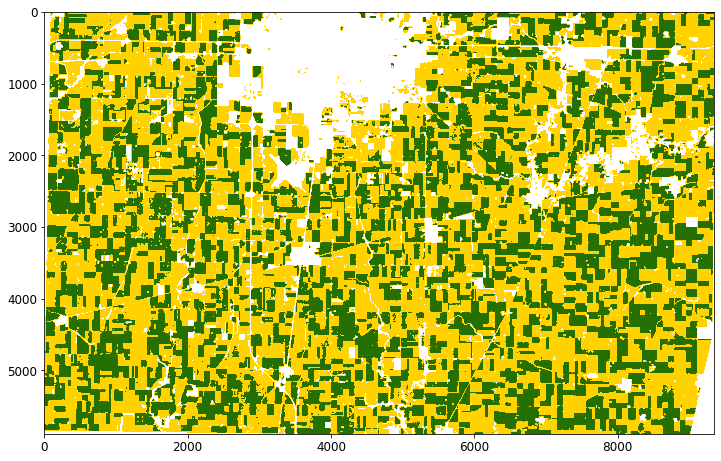

In [127]:
plt_labels(final_figure)
plt.show()

This result is not as I expected. There appear to be some strange artifacts along what might be the chunk boundaries. I wonder if this is as a result of numpy not joining the array in the same way it was chunked. Despite that, it seems like there is way more soybean than should be there.

I wonder if the model is actually performing well on invidual chunks. I can try this on some of the original validation data:

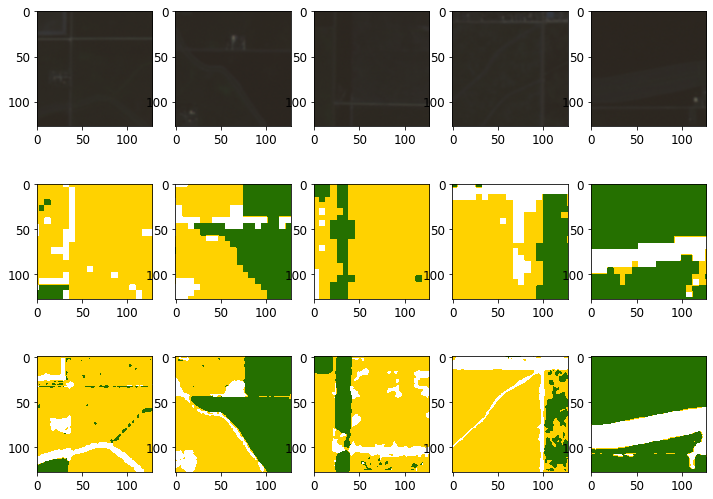

In [173]:
plt.figure(figsize=(12, 9))
chunk_indicies = np.random.randint(0, validation_X.shape[0], 5)
predictions = model(validation_X[chunk_indicies])

# The model returns predictions as probabilites.
# argmax will convert this to the class based on the max probability's index.
predictions = np.argmax(predictions, axis=-1)

for i in range(5):
    plt.subplot(3, 5, i + 1)
    # validation_X has been normalized, so just pass it directly to imshow
    # Adding .1 should make the pictures a little brighter
    plt.imshow(validation_X[chunk_indicies[i]][:, :, :3] + 0.1)

    plt.subplot(3, 5, i + 6)
    plt_labels(validation_Y[chunk_indicies[i]])

    plt.subplot(3, 5, i + 11)
    plt_labels(predictions[i])

plt.show()


Those still seem pretty accurate. Either the model is drastically overfitting the training and validation data, or the rejoining of chunks is not working as expected.